# Convolution basics

In this script we see the basics of convolution functions, their parameters, and the main operations/layers used in convolutional neural networks.

Check the documentation for more details: https://pytorch.org/docs/stable/nn.html#convolution-layers

In [1]:
import torch
import torch.nn as nn
import torchvision
from matplotlib import pyplot as plt

### Example image

In [2]:
# We provide a simple function to plot batches of tensors of dimensions [1, 1, height, width], corresponding to black and white images
# It detaches the input tensor (removes computational graph), squeezes dimensions, and transfers it back to numpy
def myplot(x):
    plt.figure()
    plt.imshow(x.detach().squeeze().numpy(), cmap='gray')
    plt.show()
    return

In [3]:
# Load the provided example image, and convert it in black and white
image_t = torchvision.io.read_image('tdp.jpeg', mode=torchvision.io.ImageReadMode.RGB)
image_t = torchvision.transforms.functional.rgb_to_grayscale(image_t)

# Convert as a float tensor and normalize it so the values range in [0, 1]
image_t = image_t.float()
image_t /= image_t.max()

# print its shape
print('Image shape:', image_t.shape)

Image shape: torch.Size([1, 343, 550])


The tensor above (corresponding to an image) has shape `[channels, height, width]` (with `channels`=1 because it's in black and white), but in pytorch we manipulate batches of images of shape `[batch_size, channels, height, width]`. Therefore we have to add an extra dimension corresponding to the `batch_size` (=1). To do that, we use the [unsqueeze](https://pytorch.org/docs/stable/generated/torch.unsqueeze.html) function.

Image shape: torch.Size([1, 1, 343, 550])


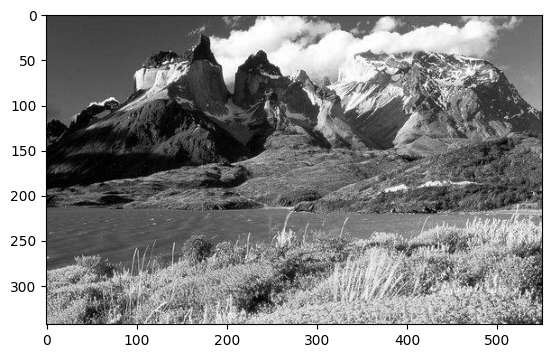

In [4]:
# TO DO: do the above, print the shape of the result, and display the image
image = torch.unsqueeze(image_t, 0)
print('Image shape:', image.shape)

myplot(image)

### Convolution

Convolution is a mathematical operation that corresponds to **filtering** the data.

For instance, in 1D convolution, we apply a 1D filter (or "kernel") to a signal (e.g., audio waveform, EEG / MEG, etc.). The kernel slides over the whole signal to compute the convolution product.

<center><a href="https://e2eml.school/convolution_one_d.html">
    <img src="https://e2eml.school/images/conv1d/aa_copy.gif"></a></center>

In this lab we will work with images, so we manipulate 2D convolution. In this case, the filter is a small matrix that slides over the input image and is multiplied by it to produce the output image. The convolution is said to be in "2D" because the kernel slides over 2 dimensions (height and width).

<center><a href="https://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/">
    <img src="http://deeplearning.stanford.edu/wiki/images/6/6c/Convolution_schematic.gif"></a></center>

On the example above, the input image (in green) is of size $5\times5$. We apply a kernel of size $3\times3$ with the following values:

$$
\begin{bmatrix}
1 & 0 & 1\\
0 & 1 & 0\\
1 & 0 & 1
\end{bmatrix}
$$

The kernel slides over the image: this means that we take a sub-block of size $3 \times 3$ (in yellow). Then, we multiply the value of the pixel with the corresponding value of the kernel; we do that for all pixels in the block and sum the results. This yields the convolution product, which is stored in the output image (on the right).

It's important to understand that applying convolution **reduces the size** of the input image.

Note that there is also 3D convolution, where the kernel slides over 3 dimensions. For instance, in video the kernel is a "cube" that slides over *height*, *width*, and an extra *time* dimension. It's theoretically possible to define convolution in any dimension, but it's not really used in practice (most applications use 1D, 2D or 3D convolution).

In [5]:
# To create a convolution function in Pytorch, we specify:
# - the number of input channels (= the depth of the input image, usually 1 for black and white images, and 3 for RGB color images
# - the number of output channels (which is equal to the number of kernels)
# - the kernel size (the dimension(s) of the filter)
# - wether to use bias or not (True by default)
num_channels_in = 1
num_channels_out = 1
kernel_size = 3
my_conv = nn.Conv2d(num_channels_in, num_channels_out, kernel_size=kernel_size, bias=False)

# You can print the kernel weights: when using Conv2d, the weights are randomly initialized
print(my_conv.weight)

Parameter containing:
tensor([[[[ 0.2086, -0.0856, -0.2463],
          [-0.3142,  0.3291,  0.1826],
          [ 0.2711,  0.1055, -0.0281]]]], requires_grad=True)


In [6]:
# It is possible to set the value of the kernel weights.
# For instance, let us set all of them to 1
my_conv.weight = nn.Parameter(torch.ones_like(my_conv.weight))
print(my_conv.weight)

Parameter containing:
tensor([[[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]]], requires_grad=True)


torch.Size([1, 341, 548])


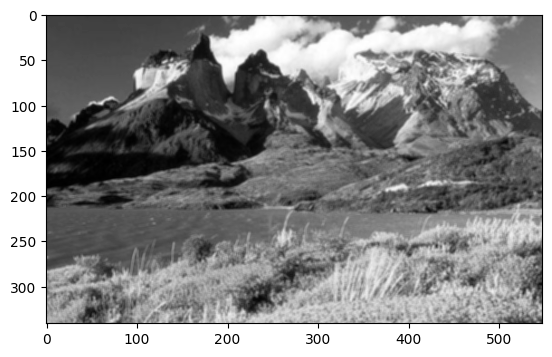

In [7]:
# Pass the image to the convolution
output = my_conv(image_t)

# Print the shape of the output, and plot it
print(output.shape)
myplot(output)

In the example above, we have set all the kernel weights to 1. Therefore, the convolution simply computes the sum of adjacent pixels in a small neighborhood (here : 3x3 squares). As a result, the output image is the same as the input, but slightly blurred because of summing the pixels.

<span style="color:red">**Exercice 1**</span> For a kernel size of 5, 10, and 20:
- create a convolution layer as above (1 input and 1 output channel, no bias
- set the kernel weights at 1
- apply convolution to the input image
- plot the output images and print its shape

What do you observe?

<span style="color:blue">**The  larger the kernel, the blurrer the image. Larger kernels cover a broad area leading to a generalized representation rather than capturing edges.**</span>

torch.Size([1, 339, 546])
Kernel size: 5


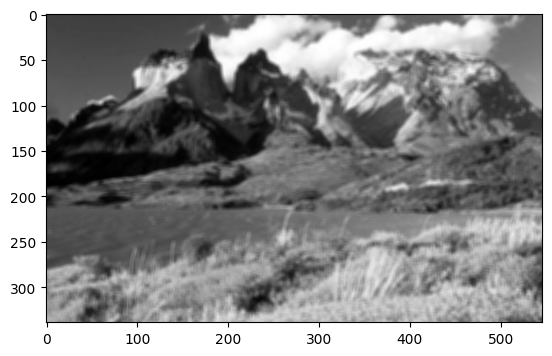

torch.Size([1, 334, 541])
Kernel size: 10


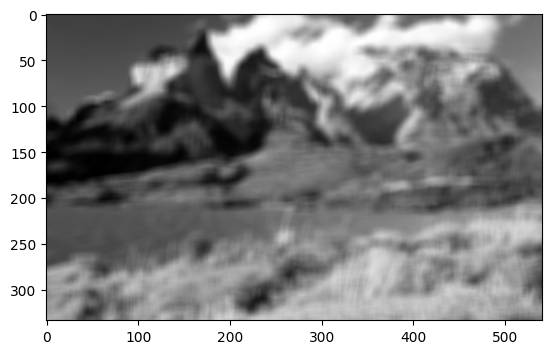

torch.Size([1, 324, 531])
Kernel size: 20


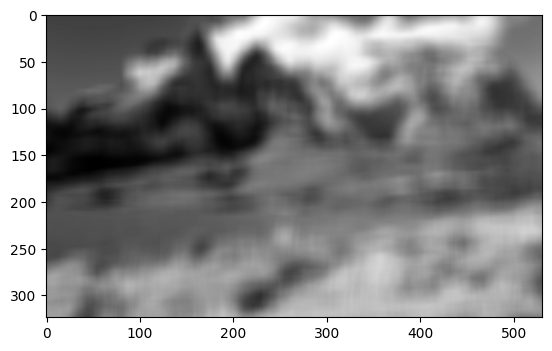

In [8]:
kernel_size = [5, 10, 20]
for k in kernel_size:
    my_conv = nn.Conv2d(num_channels_in, num_channels_out, kernel_size=k, bias=False)
    my_conv.weight = nn.Parameter(torch.ones_like(my_conv.weight))
    output = my_conv(image_t)
    print(output.shape)
    print('Kernel size: ' + str(k))
    myplot(output)



Shape : torch.Size([1, 343, 531])


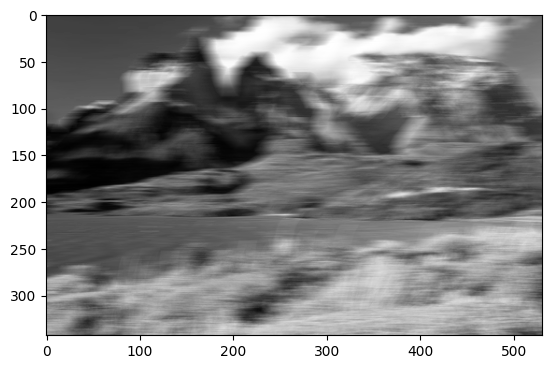

In [9]:
# We can use rectangular (= non-square) kernels, with a different lengths in height and width
my_conv = nn.Conv2d(num_channels_in, num_channels_out, kernel_size=(1, 20))
my_conv.weight = nn.Parameter(torch.ones_like(my_conv.weight), requires_grad=False)
output = my_conv(image_t)

print('Shape :', output.shape)
myplot(output)

torch.Size([1, 343, 550])


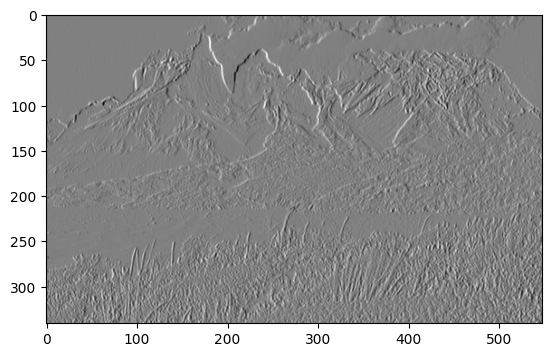

In [10]:
# Convolution can be used for many image processing applications.
# For instance, we can define a filter to detect edges in an image
edge_filter = torch.tensor([[[[-0.5, 0., 0.5], [-1., 0., 1.], [-0.5, 0., 0.5]]]])

# Then, we define a convolution and set the weights (=the kernel parameters) to this filter
my_conv = nn.Conv2d(1, 1, kernel_size=3, bias=False)
my_conv.weight = nn.Parameter(edge_filter, requires_grad=False)

# And now we apply convolution to the input image and get the edges
print(image_t.shape)
output = my_conv(image_t)
myplot(output)

### Padding

As remarked above and in the introduction, applying convolution reduces the dimension of the image as an edge effect. However, it's sometimes good to control the output dimension (e.g., to keep it the same as the input dimension). To do this, we can use **padding**, which consists in adding extra zeros on the four sides of the image: by artifically increasing the input image, we compensate for the dimension reduction in the output.

<center><a href="https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d">
    <img src="https://miro.medium.com/max/395/1*1okwhewf5KCtIPaFib4XaA.gif"></a></center>

In the example above, we use ``padding=1`` to add one row of pixels with the value 0 (white pixels within dashed lines) on the edges of the original image (in blue). Then, when we compute the convolution, this compensates for the size reduction due to a kernel size of 3, so the output image (in green) has the same shape as the original image (in blue).

In [11]:
# Create and apply a convolution without or with padding
my_conv = nn.Conv2d(num_channels_in, num_channels_out, kernel_size=3, bias=False)
output = my_conv(image_t)
my_conv_padd = nn.Conv2d(num_channels_in, num_channels_out, kernel_size=3, padding=1, bias=False)
output_padd = my_conv_padd(image_t)

# Check the size
print('Input shape :', image_t.shape)
print('Output shape, no padding: ', output.shape)
print('Output shape, with padding: ', output_padd.shape)

Input shape : torch.Size([1, 343, 550])
Output shape, no padding:  torch.Size([1, 341, 548])
Output shape, with padding:  torch.Size([1, 343, 550])


<span style="color:blue">**A padding of 2 keeps the same image size for a kernel of 5 and for a kernel of (9, 13), paddding of (4, 6) keeps the same size**</span>

In [12]:
# TO DO: write a convolution with a kernel_size=5 (1 output channel, no bias)
my_conv = nn.Conv2d(num_channels_in, num_channels_out, kernel_size=5, bias=False, padding=2)
print('Input shape without padding :', image_t.shape)   
output = my_conv(image_t)
print('Output shape, with padding: ', output.shape)
# How much padding do you need to keep the image size the same?
# Same question with a non-square kernel of size=(9, 13) (padding can also be non-square)
my_conv = nn.Conv2d(num_channels_in, num_channels_out, kernel_size=(9, 13), bias=False, padding=(4, 6))
output_non_square = my_conv(image_t)

print('Output shape, with padding: ', output_non_square.shape)


Input shape without padding : torch.Size([1, 343, 550])
Output shape, with padding:  torch.Size([1, 343, 550])
Output shape, with padding:  torch.Size([1, 343, 550])


### Stride

Sometimes, we don't want to process all the adjacent pixels in an image, but instead to "jump" from blocks of pixels to others. To do that, we can adjust the `stride` parameter of the convolution.

<center><a href="https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d">
    <img src="https://miro.medium.com/max/294/1*BMngs93_rm2_BpJFH2mS0Q.gif"></a></center>

On the illustration above, the stride is 2.

Shape :  torch.Size([1, 172, 275])


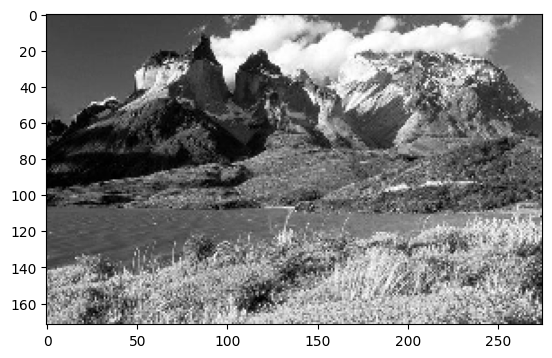

In [13]:
# Create a convolution with a kernel_size=1, weights equal to 1, but with a stride of 2:
# it's equivalent to removing every other pixel (or down-sampling the image)
my_conv = nn.Conv2d(num_channels_in, num_channels_out, kernel_size=1, stride=2, bias=False)
my_conv.weight = nn.Parameter(torch.ones_like(my_conv.weight), requires_grad=False)
output = my_conv(image_t)

print('Shape : ', output.shape)
myplot(output)

Shape :  torch.Size([1, 35, 55])


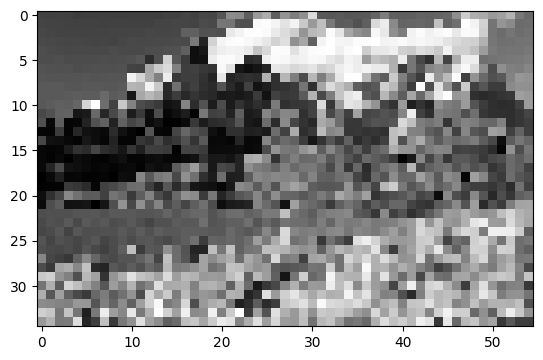

In [14]:
# TO DO: create and apply the same convolution as above, but with a stride of 10
my_conv = nn.Conv2d(num_channels_in, num_channels_out, kernel_size=1, stride=10, bias=False)
my_conv.weight = nn.Parameter(torch.ones_like(my_conv.weight), requires_grad=False)
output = my_conv(image_t)

print('Shape : ', output.shape)
myplot(output)

Shape :  torch.Size([1, 343, 184])


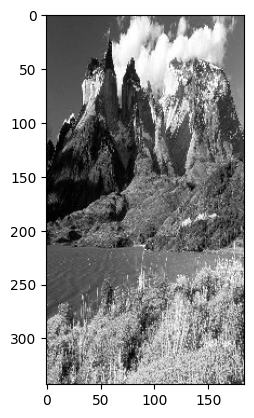

In [15]:
# TO DO: same, but with non-square stride = (1, 3)
my_conv = nn.Conv2d(num_channels_in, num_channels_out, kernel_size=1, stride=(1,3), bias=False)
my_conv.weight = nn.Parameter(torch.ones_like(my_conv.weight), requires_grad=False)
output = my_conv(image_t)

print('Shape : ', output.shape)
myplot(output)


### Pooling

For image classification / object detection, it is common in CNNs to apply a pooling function after convolution. Indeed, convolution produces output images where the important features (e.g., the detected object) might be spread over the image. The goal of pooling is to obtain a more compact representation of the image to avoid this spread, a property known as *local translation invariance*. As a result, a classification network is less sensitive to shift/translation in the image. Since it reduces the size of the data by discarding some pixels, pooling is also useful to reduce the computational load and to reduce the risk of overfitting.

<center><a href="https://medium.com/nerd-for-tech/convolutional-networks-b54335f4e21f">
    <img src="https://miro.medium.com/max/700/1*gaD6SJ6kQNVOclE_WkwLNQ.png"></a></center>

The example above uses a [max pooling](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#maxpool2d) function (= it retains the pixel with maximum value) with a size of 2 and a stride of 2 (by default in pytorch, the stride is equal to the size of the pooling). Note that there are other types of pooling, such as the [average pooling](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html) that computes the mean over the corresponding pixels.

<span style="color:red">**Exercice 2**</span> Apply max pooling on the original image with a kernel size of 10, and plot the output. Same question with average pooling. How can you interprete the difference?

Shape :  torch.Size([1, 34, 55])


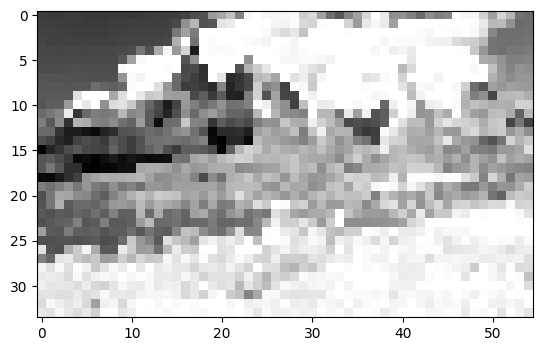

In [16]:
max_pool = nn.MaxPool2d(kernel_size=10)
output_max = max_pool(image_t)
print('Shape : ', output_max.shape)
myplot(output_max)

Shape :  torch.Size([1, 34, 55])


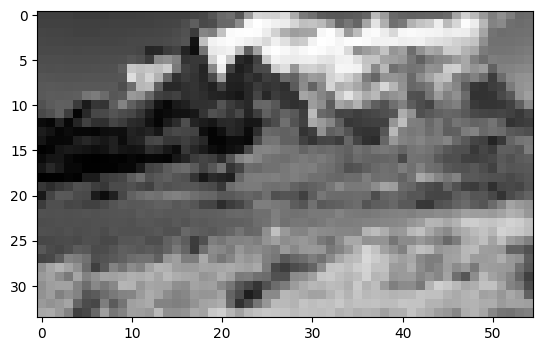

In [17]:
avg_pooling = nn.AvgPool2d(kernel_size=10)
output_avg = avg_pooling(image_t)
print('Shape : ', output_avg.shape)
myplot(output_avg)

<span style="color:blue">**The image from Max pooling tends to all white because Max pooling preserves the most significant features in every region leading to sharper contrasts and highlithed edges while average pooling is blur because it results in smoother and less detailed image as it softens the transitions by averaging the pixel values**</span>